In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Veri setini yükleme
data = pd.read_csv('0206_veriler.csv')

# Veri setini inceleme
print(data.head())
print(data.describe())


                                             Twitler  Durum
0  a101 6 nisan firsatlari\n\nucuzkenaldim \n\nre...      1
1                                         trendyol        1
2                            alisverislerime devam        1
3  kargolarimi bana ulastirmak icin defalarca ara...      1
4              favorilerimin hepsini almak isterdim       1
            Durum
count  386.000000
mean     0.500000
std      0.500649
min      0.000000
25%      0.000000
50%      0.500000
75%      1.000000
max      1.000000


In [3]:
# Veri setini eğitim ve test kümelerine ayırma
X = data['Twitler']
y = data['Durum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# ALBERT tokenizer'ını oluşturma
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)


In [5]:
# Veri setini tokenleme
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

In [6]:
# PyTorch tensörlerine dönüştürme
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(list(y_train))
train_masks = torch.tensor(train_encodings['attention_mask'])
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(list(y_test))
test_masks = torch.tensor(test_encodings['attention_mask'])

In [7]:
# GPU kullanımı için tensörleri taşıma
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
train_masks = train_masks.to(device)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)
test_masks = test_masks.to(device)


In [8]:
# ALBERT modelini yükleme
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
model.to(device)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [9]:
# Optimizer ve öğrenme oranını belirleme
optimizer = AdamW(model.parameters(), lr=1e-5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
import time

# Eğitim döngüsü
model.train()

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(10):
    optimizer.zero_grad()
    start_time = time.time()
    outputs = model(input_ids=train_inputs, attention_mask=train_masks, labels=train_labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time

    # Eğitim ve test verileri üzerinde loss değerlerini ve doğruluk değerlerini hesaplama
    train_loss_values.append(loss.item())
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        train_outputs = model(input_ids=train_inputs, attention_mask=train_masks)
        train_logits = train_outputs.logits
        train_predictions = torch.argmax(train_logits, dim=1)
        train_accuracy = accuracy_score(list(train_labels.cpu()), list(train_predictions.cpu()))
        train_accuracy_values.append(train_accuracy)

        test_outputs = model(input_ids=test_inputs, attention_mask=test_masks)
        test_logits = test_outputs.logits
        test_predictions = torch.argmax(test_logits, dim=1)
        test_accuracy = accuracy_score(list(test_labels.cpu()), list(test_predictions.cpu()))
        test_accuracy_values.append(test_accuracy)
        end_time = time.time()
        test_time = end_time - start_time
    
    model.train()

    # Epoch numarasını, loss değerini ve süreleri yazdırma
    print("Epoch:", epoch+1, "Loss:", loss.item(), "Train Time:", epoch_time, "Test Time:", test_time)

Epoch: 1 Loss: 0.7132194638252258 Train Time: 102.62932205200195 Test Time: 16.983733892440796
Epoch: 2 Loss: 0.6739713549613953 Train Time: 102.56866884231567 Test Time: 17.166915893554688
Epoch: 3 Loss: 0.6743139028549194 Train Time: 110.35020017623901 Test Time: 18.61780309677124
Epoch: 4 Loss: 0.6263386011123657 Train Time: 101.58491706848145 Test Time: 16.73123812675476
Epoch: 5 Loss: 0.5978353023529053 Train Time: 100.15835499763489 Test Time: 16.897902727127075
Epoch: 6 Loss: 0.5734456777572632 Train Time: 99.25776624679565 Test Time: 16.718651056289673
Epoch: 7 Loss: 0.5235280394554138 Train Time: 100.34852504730225 Test Time: 17.499055862426758
Epoch: 8 Loss: 0.48035693168640137 Train Time: 104.31423211097717 Test Time: 17.55485701560974
Epoch: 9 Loss: 0.4298056662082672 Train Time: 102.41699123382568 Test Time: 17.75636577606201
Epoch: 10 Loss: 0.39244404435157776 Train Time: 102.97457027435303 Test Time: 17.279542684555054


In [11]:
#Değerlendirme metriklerini hesaplama
predictions = torch.argmax(test_logits, dim=1)
accuracy = accuracy_score(list(test_labels.cpu()), list(predictions.cpu()))
precision = precision_score(list(test_labels.cpu()), list(predictions.cpu()))
recall = recall_score(list(test_labels.cpu()), list(predictions.cpu()))
f1 = f1_score(list(test_labels.cpu()), list(predictions.cpu()))

#Sonuçları yazdırma
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

import matplotlib.pyplot as plt

Accuracy: 0.6282051282051282
Precision: 0.6851851851851852
Recall: 0.7551020408163265
F1-Score: 0.7184466019417475


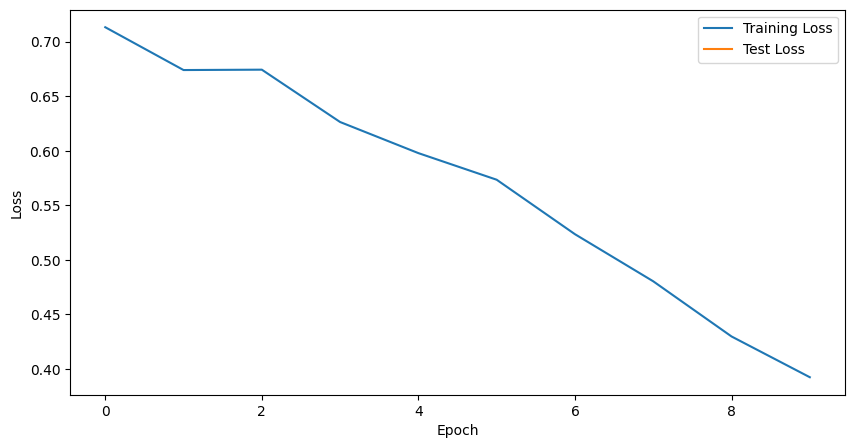

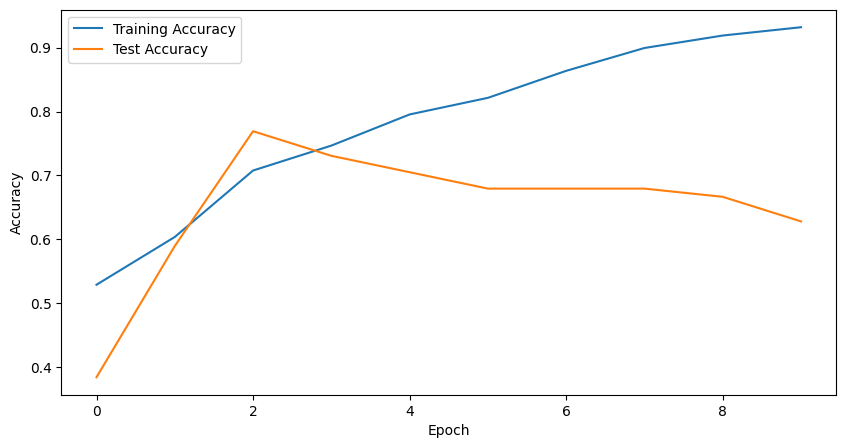

In [12]:
#Eğitim ve test loss değerlerini ve doğruluk değerlerini grafiğe dökme

plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()